Import Of The Important Libraries Required for Solving This Problem.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string 
import re
from nltk.corpus import stopwords
from collections import Counter

In [3]:
os.listdir()

['.ipynb_checkpoints',
 'Sentiment_Analysis_Udacity.ipynb',
 'txt_sentoken',
 'review_polarity']

# Preprocessing Step 
# Import Data

In [4]:
# Function to load document into the notebook
def load_document(fileName):
    file=open(fileName,'r')
    text_data=file.read()
    file.close()
    return text_data

In [5]:
# Data Cleaning Step
# Turn a document into tokens after processing it.

def clean_document(document):
    #split the review into tokens by white space
    tokens=document.split()
    # regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # removetokens which are not alphabetis
    tokens = [word for word in tokens if word.isalpha()]
    # remove stop words
    ##  A stop word is a commonly used word (such as “the”, “a”, “an”, “in”)
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # remove out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    
    return tokens

In [6]:
filename="txt_sentoken/pos/cv001_18431.txt"
text=load_document(filename)
tokens=clean_document(text)
print(tokens[:10])

['every', 'movie', 'comes', 'along', 'suspect', 'studio', 'every', 'indication', 'stinker', 'everybodys']


In [7]:
# Function to save list to file
def save_list(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [8]:
# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
    # load the doc
    doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [w for w in tokens if w in vocab]
    return ' '.join(tokens)

In [9]:
# directory='txt_sentoken/neg'
# for file in os.listdir(directory):
#     if file.endswith(".txt"):
#         doc=load_document(directory+'/'+file)
#         print("Loaded Document %s" % file)

# Develop Vocabulary

In [10]:
# Function to Load Document and then add the words to Vocab
def document_to_vocabulary(fileName,vocab):
    document=load_document(fileName)
    tokens=clean_document(document)
    vocab.update(tokens)

In [11]:
# Function to Process All the documents in the Directory
def process_documents(directory, vocab):
    count=0
    for fileName in os.listdir(directory):
        if fileName.endswith(".txt"):
            path=directory+"/"+fileName
            document_to_vocabulary(path,vocab)
            count+=1
    print("Total Number Of Files Processed In {d} = {n}".format(d=directory,n=count))

In [39]:
# Main Function To Process the documents 
# Global Varaible To Store The Count 

vocab = Counter()

def develop_vocab():
    global vocab
#     vocab= Counter()
    process_documents('txt_sentoken/neg', vocab)
    process_documents('txt_sentoken/pos', vocab)
    
    min_occur = 5
    tokens = [k for k,c in vocab.items() if c >= min_occur]
    save_list(tokens,"vocab.txt")

develop_vocab()

Total Number Of Files Processed In txt_sentoken/neg = 1000
Total Number Of Files Processed In txt_sentoken/pos = 1000


In [40]:
#Check Whether The File is Create or not 
if "vocab.txt" in os.listdir():
    print("TRUE")

TRUE


In [41]:
#print Length of the Vocabulary
print("Total Length Of The Vocabulary %s" %len(vocab))

Total Length Of The Vocabulary 46557


In [42]:
# 50 Most Common Words
print(vocab.most_common(50))

[('film', 8860), ('one', 5521), ('movie', 5440), ('like', 3553), ('even', 2555), ('good', 2320), ('time', 2283), ('story', 2118), ('films', 2102), ('would', 2042), ('much', 2024), ('also', 1965), ('characters', 1947), ('get', 1921), ('character', 1906), ('two', 1825), ('first', 1768), ('see', 1730), ('well', 1694), ('way', 1668), ('make', 1590), ('really', 1563), ('little', 1491), ('life', 1472), ('plot', 1451), ('people', 1420), ('movies', 1416), ('could', 1395), ('bad', 1374), ('scene', 1373), ('never', 1364), ('best', 1301), ('new', 1277), ('many', 1268), ('doesnt', 1267), ('man', 1266), ('scenes', 1265), ('dont', 1210), ('know', 1207), ('hes', 1150), ('great', 1141), ('another', 1111), ('love', 1089), ('action', 1078), ('go', 1075), ('us', 1065), ('director', 1056), ('something', 1048), ('end', 1047), ('still', 1038)]


# Top Ten Most Common Words

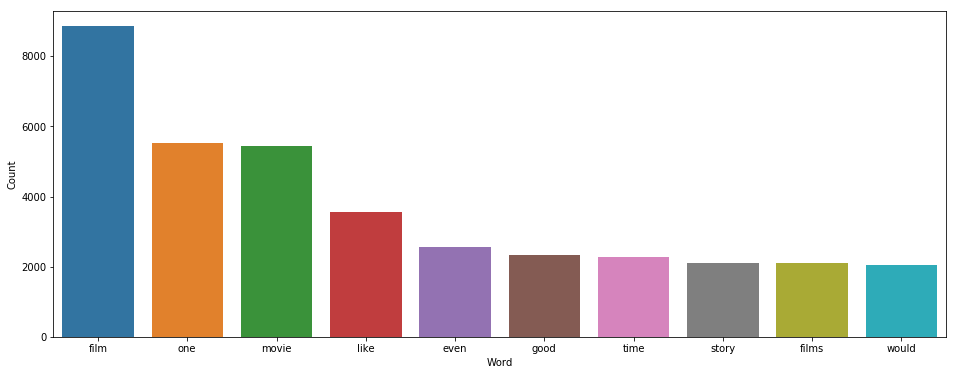

In [43]:
vocabmcdf=pd.DataFrame(data=vocab.most_common(10),columns=['Word','Count'])
plt.figure(figsize=(16,6))
sns.barplot(x='Word',y="Count",data=vocabmcdf)

In [70]:
#Load The Vocabulary from Vocab.txt File.

vocab_data=load_document("vocab.txt")
vocab_data=vocab_data.split()
vocab=set(vocab_data)
print("Number of Words in Vocab.txt is %s" %len(vocab))

Number of Words in Vocab.txt is 14803


# Prepare Review For Modeling

Creating Negative.txt and Positive.txt from all the review documents.

In [89]:
def process_review_documents(directory,vocab):
    lines=[]
    count=0
    for file in os.listdir(directory):
#         print(file)
        if file.endswith(".txt"):
#             
            count+=1
            file_path=directory + '/' + file
            lines_in_file=load_document(file_path)
            tokens=clean_document(lines_in_file)
            tokens=[w for w in tokens if w in vocab]
            line=' '.join(tokens)
        lines.append(line)
#         print(lines)
    print("Number of File Processed in {d} is {n}".format(d=directory,n=count))
    return lines

# Negative lines from all the documents from "txt_sentoken/neg"

In [94]:
# Negative lines from all the documents from "txt_sentoken/neg"
neg_lines=process_review_documents("txt_sentoken/neg",vocab_data)
save_list(neg_lines,"negative.txt")

#Load Negative Lines From negative.txt
negative_lines=load_document("negative.txt")
print("Length of the Negative.txt File is %s " %len(negative_lines))


Number of File Processed in txt_sentoken/neg is 1000
Length of the Negative.txt File is 2124581 


In [95]:
print(negative_lines[:100])

studio attracted many weird bizarre people gates wonder film life death studio centers one boring cl


# Positive lines from all the documents from "txt_sentoken/pos"

In [96]:
# Negative lines from all the documents from "txt_sentoken/neg"
pos_lines=process_review_documents("txt_sentoken/pos",vocab_data)
save_list(pos_lines,"positive.txt")

#Load Negative Lines From negative.txr
positive_lines=load_document("positive.txt")
print("Length of the Positive.txt File is %s " %len(positive_lines))


Number of File Processed in txt_sentoken/pos is 1000
Length of the Positive.txt File is 2408780 


In [97]:
print(positive_lines[:100])

david lynchs blue velvet begins ends colorful bright shots flowers happy americans seemingly perfect
